In [3]:
#this cell has what you will need to import

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as optimise
from scipy import signal
import re
import fnmatch

#I use these to loop over the directories
import os
from pathlib import Path

from astropy.io import fits #to read a fits file

#I use this package to convert from redshift to year
#Renyue implied doing this conversion is trivial
#but it is not. I suggest reading up on this
#package and then using it.
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.272)

In [4]:
def read_sun(director):
    
    
    masses=[] 
    sfrs=[]
    metals=[]
    ages=[]
    
    for filename in os.listdir(director):
        
        if filename.startswith('sun'):
            
            sfile=director+'/'+filename
                    
            hdul = fits.open(sfile)
            data=hdul[4].data                
            hdul.close()
                    
            #here I calculate the star formation rate as the total
            #mass of star particles less than a Myr old
            good_age=data['age']<1e6
            sfr = sum(data['mass'][good_age])/1e6
            
            masses.append(np.array(data['mass']))
            sfrs.append(sfr)
            metals.append(np.array(data['metallicity']))
            ages.append(np.array(data['age']))
                    

    masses=np.array(masses)
    sfrs=np.array(sfrs)
    metals=np.array(metals)
    ages=np.array(ages)
    

    return masses,sfrs,metals,ages

In [5]:
mass,sfr,metals,ages=read_sun('out01461')

In [6]:
hdul = fits.open('sb99kroupa4.fits')
data = hdul[1].data[0]

In [7]:
def plot_mass_hist(galaxy):
    max_age = int(max(ages[galaxy]))
    digits = len(str(max_age))
    max_bin = int(np.ceil(max_age / 10**(digits-1))) * 100
    fig = plt.figure()
    plt.hist(ages[galaxy], bins = np.arange(max_bin)*1e6, weights = mass[galaxy])
    plt.title("Histogram of star particles ages in galaxy %i, weighted by mass" % galaxy)
    plt.ylabel("Total star particle mass ($M_\odot$)")
    plt.xlabel("Star particle age (years)")
    return fig

In [8]:
def calc_mass_hist(galaxy):
    max_age = int(max(ages[galaxy]))
    digits = len(str(max_age))
    max_bin = int(np.ceil(max_age / 10**(digits-1))) * 100
    n, bins = np.histogram(ages[galaxy], bins = np.arange(max_bin)*1e6, weights = mass[galaxy])
    return n,bins

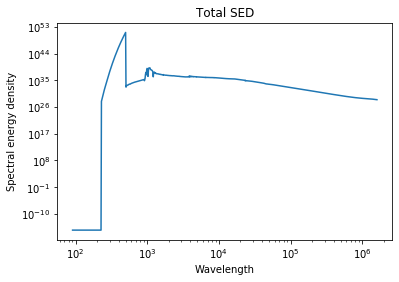

In [9]:
#gives the index of the closest array element to the value
def find_nearest(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx

#gives the weighting of the star particle in time or metallicity using a logarithmic scaling
def logwtg(value, array):
    lindex = np.searchsorted(array, value, side='right')-1
    weight = np.log(value/array[lindex])/np.log(array[lindex+1]/array[lindex])
    return lindex, weight

#Finding nearest-neighbour index for each sun's age and metallicity
totlogwtsed = np.zeros(len(data['wave'])) #empty array to sum up the SED
totlogwtsed = np.array(totlogwtsed, dtype=np.float128)
for i in range(len(ages[2])): #for each particle
    aindex, aweight = logwtg(ages[2][i], data['tgrid'])#finding the closest values for the age and metallicity
    zindex, zweight = logwtg(metals[2][i], data['zgrid'])
    wtSED = aweight*(zweight*data['sed'][zindex+1,aindex+1,:]+(1-zweight)*data['sed'][zindex,aindex+1,:])+(1-aweight)*((zweight*data['sed'][zindex+1,aindex,:]+(1-zweight)*data['sed'][zindex,aindex,:]))
    massnormSED = wtSED+np.log10(mass[2][i]/1e6) #normalise by star particle mass, in a logarithmic sense
    unloggedSED = np.power(10, massnormSED, dtype=np.float128)
    totlogwtsed = np.add(totlogwtsed, unloggedSED)

plt.plot(data['wave'], totlogwtsed)
plt.title("Total SED")
plt.xlabel("Wavelength")
plt.ylabel("Spectral energy density")
plt.xscale('log')
plt.yscale('log')

[0, 4, 8, 113, 118, 135, 141, 351, 360]


array([0.00e+00, 4.00e+06, 8.00e+06, 1.13e+08, 1.18e+08, 1.35e+08,
       1.41e+08, 3.51e+08, 3.60e+08])

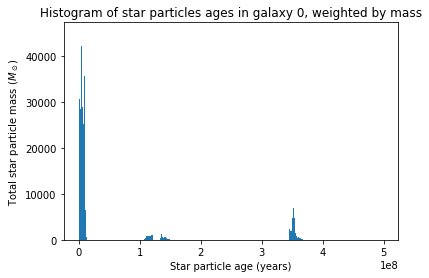

In [160]:
def find_peaks(galaxy):
    n, bins = calc_mass_hist(galaxy)
    peaks = [0]
    result = signal.find_peaks(n, height = 0.01 * max(n), width = 1)[0].tolist()
    peaks = peaks + result
    return peaks, n, bins

plot_mass_hist(0)
peaks, n, bins = find_peaks(0)

print(peaks)

bins[peaks]

In [161]:
peaks, n, bins = find_peaks(0)

print(bins[peaks])

peakage(1, 0)

[0.00e+00 4.00e+06 8.00e+06 1.13e+08 1.18e+08 1.35e+08 1.41e+08 3.51e+08
 3.60e+08]


(1.0, 0.0)

In [162]:
def peakage(age, galaxy):
    peaks, n, bins = find_peaks(galaxy)
    peak_years = bins[peaks]
    lastpeak = peak_years[np.searchsorted(peak_years, age, side='right')-1]
    relage = age-lastpeak
    return relage, lastpeak

In [176]:
rel_ages = []
rel_age_SED = []

#try:
    #index_value = rel_ages.index(44)
#except ValueError:
    #index_value = -1
#print(index_value)

# expected size = 431

totrelageSED = np.zeros((210, len(data['wave'])))



def find_nearest(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx

#gives the weighting of the star particle in time or metallicity using a logarithmic scaling
def logwtg(value, array):
    lindex = np.searchsorted(array, value, side='right')-1
    weight = np.log(value/array[lindex])/np.log(array[lindex+1]/array[lindex])
    return lindex, weight


for i in range(len(ages[0])): #for each particle in galaxy 0
    aindex, aweight = logwtg(ages[0][i], data['tgrid'])#finding the closest values for the age and metallicity
    zindex, zweight = logwtg(metals[0][i], data['zgrid'])
    wtSED = aweight*(zweight*data['sed'][zindex+1,aindex+1,:]+(1-zweight)*data['sed'][zindex,aindex+1,:])+(1-aweight)*((zweight*data['sed'][zindex+1,aindex,:]+(1-zweight)*data['sed'][zindex,aindex,:]))
    massnormSED = wtSED+np.log10(mass[0][i]/1e6) #normalise by star particle mass, in a logarithmic sense
    unloggedSED = np.power(10, massnormSED, dtype=np.float128)
        
    relage, lastpeak = peakage(ages[0][i],0)
    
    if (relage < 0):
        print("whoops", ages[0][i], relage)
    try:
        age_index = rel_ages.index(int(relage/1e6))
    except ValueError:
        age_index = -1
    
    #age_index = np.where(rel_ages == int(relage/1e6))
    #print(int(relage/1e6))
    
    #print(len(age_index[0]))
    if (age_index == -1):
        rel_ages.append(int(relage/1e6))
        rel_age_SED.append(unloggedSED)
    else:
        rel_age_SED[age_index] = np.add(rel_age_SED[age_index], unloggedSED)
        
        
    
    totrelageSED[int(relage/1e6)] = np.add(totrelageSED[int(relage/1e6)], unloggedSED)
    #age_index = np.where(rel_ages_array == int(relage))
    #print(age_index[0])
    #print(len(age_index[0]))
    #if (len(age_index[0]) == 0):
        #rel_age_SED.append(unloggedSED)
        #rel_ages_array.append(int(relage))
    #else:
        #rel_age_SED[age_index[0][0]] = np.add(rel_age_SED[age_index[0][0]], unloggedSED)
    

In [178]:
#SED_array = np.array(rel_age_SED)
print(np.shape(rel_age_SED))
#print(np.nonzero(totrelageSED))
#print(totrelageSED[430])
#print(rel_ages)

count = 0

for SED in totrelageSED:
    if SED.all():
        count+=1

print(max(rel_ages))
print(totrelageSED[209])
print(rel_age_SED[0])

(39, 1221)
209
[4.83417379e-18 4.83417379e-18 4.83417379e-18 ... 2.77308178e+26
 1.50416936e+26 8.81377837e+25]
[4.83417379e-18 4.83417379e-18 4.83417379e-18 ... 2.77308178e+26
 1.50416936e+26 8.81377837e+25]


4
